## Import Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import copy
import sys
import cv2
import os

## Import data

Function for importing data

In [2]:
# Specify image size
img_size = 224

# Making function for create data from path
def create_data():
    
    # Specify images path
    
    Kane = 'C:/Users/124ab/ML upasana/Sports-celebrity images/Kane Williamson'
    Kobe = 'C:/Users/124ab/ML upasana/Sports-celebrity images/Kobe Bryant'
    Maria = 'C:/Users/124ab/ML upasana/Sports-celebrity images/Maria Sharapova/'
    Ronaldo =  'C:/Users/124ab/ML upasana/Sports-celebrity images/Ronaldo'
    
    
    # Labels
    Labels = {Kane:0, Kobe:1, Maria:2, Ronaldo:3}
    
    # Initializing list for storing data
    data = []
    
    # Initializing list for storing label
    labels = np.array([])
    
    # Looping through each label
    for label in Labels:
        
        # Looping through each category > (Kane, Kobe, Maria, Ronaldo)
        for ls in os.listdir(label):
            
            # Join each ls element with file path
            path = os.path.join(label, ls)

            # Read images from path using cv2
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (img_size, img_size))

            # Convert color from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            

            # Adding data into data and labels list
            data.append(np.array(img))
            labels = np.append(labels, Labels[label])


    return np.array(data), labels

In [3]:
# Create data and labels
data, labels = create_data()

# Look at data size
print(f"Data with shape {data.shape}")
print(f"Label with shape {labels.shape}")

Data with shape (441, 224, 224, 3)
Label with shape (441,)


## Look at our images !!

Function for showing image

In [4]:
# Function for showing images
def show_img(dataset, label):
    # Randomly choose image index
    random_idx = np.random.randint(low=0, high=dataset.shape[0], size=10)

    # Initializing fig and ax variables
    fig, axs = plt.subplots(2, 5, figsize=(16,8))

    # Looping through each axs
    for i, ax in enumerate(axs.flatten()):

        # Showing image
        ax.imshow(dataset[random_idx[i],:], cmap='gray')
        ax.axis('off')
        
        # Set title for each image
        if label[random_idx[i]] ==0:
            ax.set_title("Kane Williamson")
        elif label[random_idx[i]] ==1:
            ax.set_title("Kobe Bryant")
        elif label[random_idx[i]] ==2:
            ax.set_title("Maria Sharapova")
        elif label[random_idx[i]] ==3:
            ax.set_title("Ronaldo")
    fig.tight_layout()
    plt.show()

Look at images!

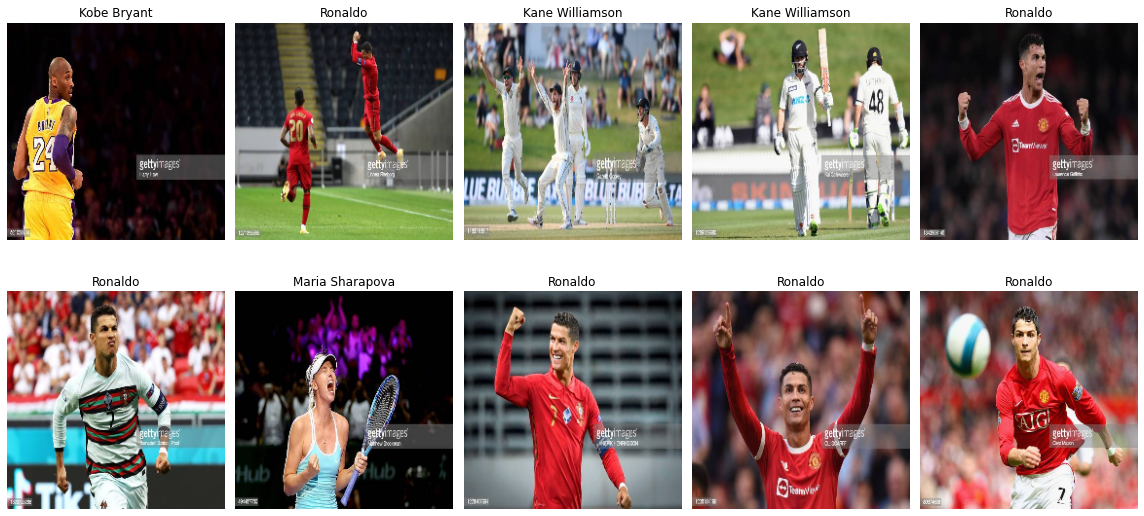

In [5]:
show_img(data, labels)

## Data Augmentation to increase data size

Normalize data

In [6]:
data = data / np.max(data)
print(f"Min of data is {np.min(data)}")
print(f"Max of data is {np.max(data)}")

Min of data is 0.0
Max of data is 1.0


Randomly flip data and adding noise to it!

In [7]:
# Copy data variable and store in flip_data variable
flip_data = copy.deepcopy(data)

# random index to flip!
flip_idx = np.round(np.random.rand(flip_data.shape[0]))

# Flip it!
for idx in range(len(flip_idx)):
    
    # Check if flip_idx is 1 then flip it. On the other hands, i will add noise instead!
    if flip_idx[idx] == 1:
        flip_data[idx,:] = cv2.flip(flip_data[idx], -1)
    
    # Adding noise for flip_idx is 0
    else:
        flip_data[idx, :] = flip_data[idx,:] + np.random.rand(*flip_data[idx].shape)
        flip_data[idx, :] /= np.max(flip_data[idx,:])

Look at our result!

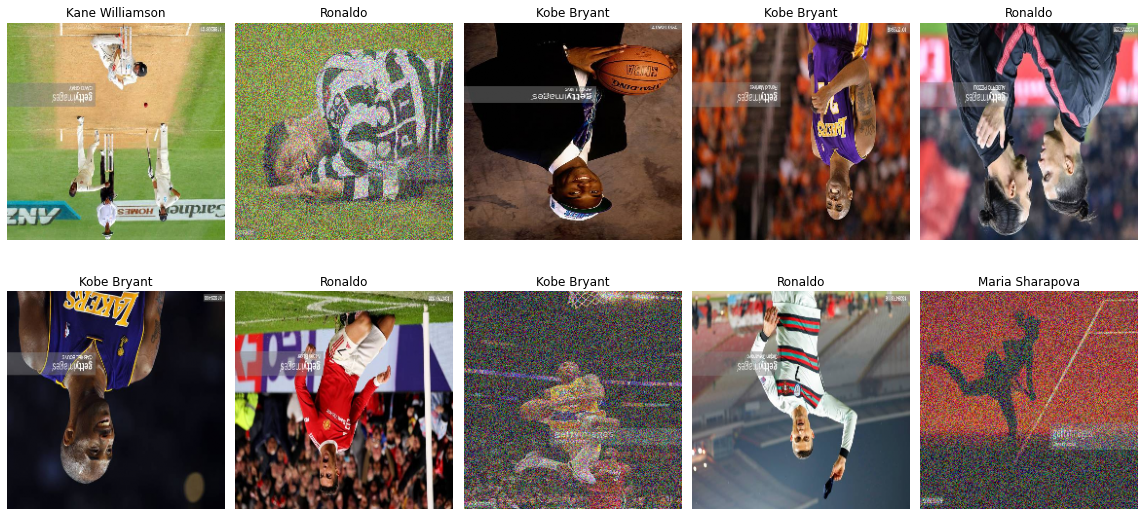

In [8]:
show_img(flip_data, labels)

Concatenate result to data

In [9]:
# Concat data with flip_data variable
data = np.concatenate((data, flip_data))

# Concat labels twice because we use same data twice
labels = np.concatenate((labels, labels))


show images again with full dataset and print its size

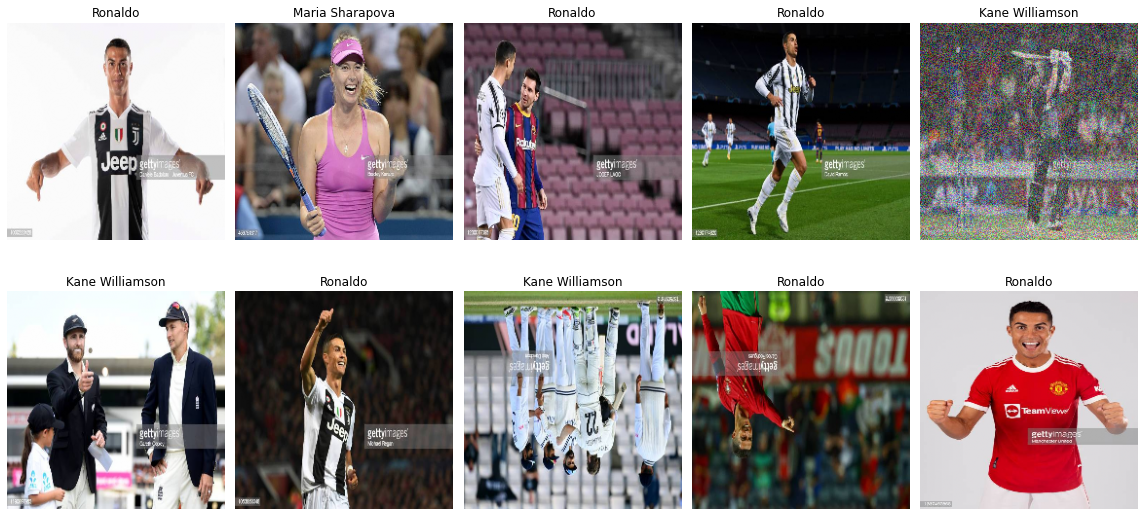

(882, 224, 224, 3)


In [10]:
show_img(data, labels)
print(data.shape)

## Split data into train and test set

Convert numpy array into torch.tensor

In [11]:
# Reshape data to (num_of_pic, 3, img_size, img_size) then convert it to torch.tensor
data_T = torch.tensor(data.reshape(data.shape[0], 3, img_size, img_size)).float()

# convert label to torch.tensor with long type
labels_T = torch.tensor(labels).long()

# Look at their shape!
print(data_T.shape)
print(labels_T.shape)

torch.Size([882, 3, 224, 224])
torch.Size([882])


Split train and test set with train_test_split from sklearn

In [12]:
train_data, test_data, train_label, test_label = train_test_split(data_T, labels_T,
                                                                 test_size=.2, stratify=labels_T,
                                                                 random_state=555)
print(f"Train data shape {train_data.shape}")
print(f"Test data shape {test_data.shape}")

Train data shape torch.Size([705, 3, 224, 224])
Test data shape torch.Size([177, 3, 224, 224])


## Create DataLoader object

Make TensorDataset!

In [13]:
train_ts = torch.utils.data.TensorDataset(train_data, train_label)
test_ts = torch.utils.data.TensorDataset(test_data, test_label)

Let's create DataLoader !

In [14]:
train_loader = torch.utils.data.DataLoader(train_ts, batch_size=35, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_ts, batch_size=10, shuffle=True)

## Create function for training

Checking for GPU

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Function for trainning

In [16]:
def train_model(model, lossfunc, optimizer, n_epochs, train_data, val_data):
    
    # For storing best perfrom model!
    bestmodel = {'acc': 0, 'net': None}
    
    # Initializing variables for storing result
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    
    # Use GPU for our model
    model = model.to(device)
    
    # Training loop
    for epochi in range(n_epochs):
        
        # Training mode
        model.train()
        
        # Variable for storing result each batch
        batch_train = []
        batch_loss = []
        
        # Training in train_data
        for X, y in train_data:
            
            # Push data into GPU
            X = X.to(device)
            y = y.to(device)
            
            # Predict model
            pred = model(X)
            # How many error in this prediction ? (compute for error)
            loss = lossfunc(pred, y)
            
            # Set gradient to zero
            optimizer.zero_grad()
            # Compute Loss
            loss.backward()
            # Do back prop
            optimizer.step()
            
            # Storing loss this batch into batch_loss
            batch_loss.append(loss.item())
            
            # move pred, y to CPU
            pred = pred.cpu()
            y = y.cpu()
            
            # Computing accuracy and storing result
            matches = (torch.argmax(pred, axis=1) == y).float()
            batch_train.append(100*torch.mean(matches).item())
        
        # Compute average of batch_train and batch_loss
        train_acc.append(np.mean(batch_train))
        train_losses.append(np.mean(batch_loss))
            
        # Using eval mode
        model.eval()
        
        batch_val = []
        batch_val_loss = []
        # Testing in validation_data to avoid overfitting
        for X, y in val_data:
        
            # Push data into GPU
            X = X.to(device)
            y = y.to(device)

            # Using torch.no_grad() to switch off gradient computation
            with torch.no_grad():
                # Predict model
                pred = model(X)

            loss = lossfunc(pred, y)
            # Store test loss
            batch_val_loss.append(loss.item())

            # move pred to CPU
            pred = pred.cpu()
            y = y.cpu()

            matches = (torch.argmax(pred, axis=1) == y).float()
            batch_val.append(100*torch.mean(matches).item())
        
        val_acc.append(np.mean(batch_val))
        val_losses.append(np.mean(batch_val_loss))
        # Craete msg for printing result
        msg = f"Epoch {epochi+1} out of {n_epochs} with Train acc {train_acc[-1]:.2f}% Val acc {val_acc[-1]:.2f}% and Val Loss {val_losses[-1]:.8f}"
        sys.stdout.write('\r'+msg)
        
        # Storing bestmodel
        if val_acc[-1] > bestmodel['acc']:
            
            bestmodel['acc'] = val_acc[-1].item()
            bestmodel['net'] = copy.deepcopy(model.state_dict())
    
    return train_acc, val_acc, train_losses, val_losses, model, bestmodel

## Resnet50 !!

Import ResNet50 model from torchvision

In [17]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Change out_features from Output layer

In [18]:
resnet50.fc = nn.Linear(2048, 4)
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Making loss function and optimizer for vgg16

In [19]:
resnet50lossfunc = nn.CrossEntropyLoss()
resnet50optimizer = torch.optim.Adam(resnet50.parameters(), lr=.001)

In [20]:
train_acc, val_acc, train_losses, val_losses, resnet50, bestresnet50 = train_model(resnet50, resnet50lossfunc,
                                                                            resnet50optimizer, 50,
                                                                            train_loader, test_loader)

Epoch 50 out of 50 with Train acc 95.29% Val acc 58.41% and Val Loss 1.87023084

Let's look at bestmodel!

In [21]:
bestresnet50['acc']

63.174603548314835

Plot ResNet50 performance!

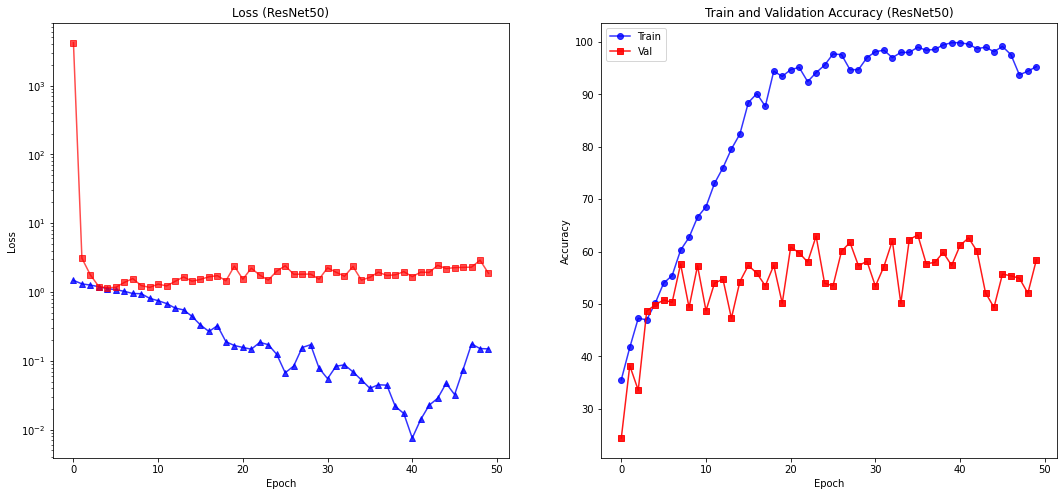

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plot loss
axs[0].plot(train_losses, 'b^-', alpha=.8)
axs[0].plot(val_losses, 'rs-', alpha=.7)
axs[0].set_yscale('log')
axs[0].set_title('Loss (ResNet50)')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

axs[1].plot(train_acc, 'bo-', alpha=.8, label='Train')
axs[1].plot(val_acc, 'rs-', alpha=.9, label='Val')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Train and Validation Accuracy (ResNet50)")
axs[1].legend()
plt.show()

What about other model? We should try !

## VGG-16

In [23]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Change output layer !

In [24]:
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Set loss function and optimizer then train it!!

In [25]:
vgg16lossfunc = nn.CrossEntropyLoss()
vgg16optimizer = torch.optim.Adam(vgg16.parameters(), lr=.001)

In [26]:
train_acc, val_acc, train_losses, val_losses, vgg16, bestvgg16 = train_model(vgg16, vgg16lossfunc,
                                                                            vgg16optimizer, 50,
                                                                            train_loader, test_loader)

Epoch 50 out of 50 with Train acc 27.29% Val acc 26.67% and Val Loss 1.38536377

Look at best vgg16 model

In [27]:
bestvgg16['acc']

34.68254026439455

It looks like vgg16 didn't do well in this dataset :C. However, let's see plotting

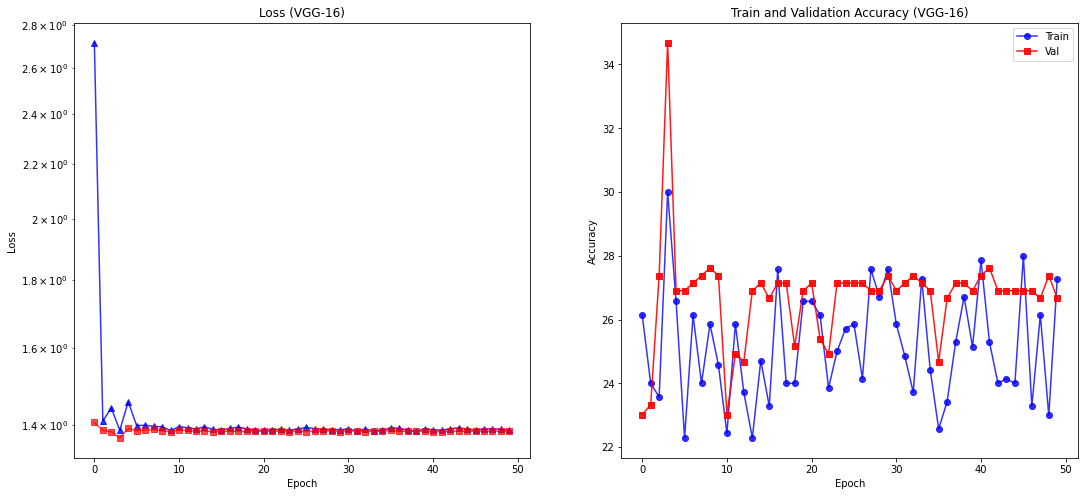

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plot loss
axs[0].plot(train_losses, 'b^-', alpha=.8)
axs[0].plot(val_losses, 'rs-', alpha=.7)
axs[0].set_yscale('log')
axs[0].set_title('Loss (VGG-16)')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

axs[1].plot(train_acc, 'bo-', alpha=.8, label='Train')
axs[1].plot(val_acc, 'rs-', alpha=.9, label='Val')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Train and Validation Accuracy (VGG-16)")
axs[1].legend()
plt.show()

## GoogleNet

In [29]:
gnet = torchvision.models.googlenet(pretrained=True)
gnet

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

Change output layer

In [30]:
gnet.fc = nn.Linear(in_features=1024, out_features=4, bias=True)
gnet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

Create lossfunction and optimzier

In [31]:
gnetlossfunc = nn.CrossEntropyLoss()
gnetoptimizer = torch.optim.Adam(gnet.parameters(), lr=.001)

Train it!

In [32]:
train_acc, val_acc, train_losses, val_losses, gnet, bestgnet = train_model(gnet, gnetlossfunc,
                                                                            gnetoptimizer, 50,
                                                                            train_loader, test_loader)

Epoch 50 out of 50 with Train acc 99.71% Val acc 60.95% and Val Loss 1.40944820

Check best gnet (googlenet) :P

In [33]:
bestgnet['acc']

65.95238116052415

WoW that looks really great ! let's see how it looks in graph

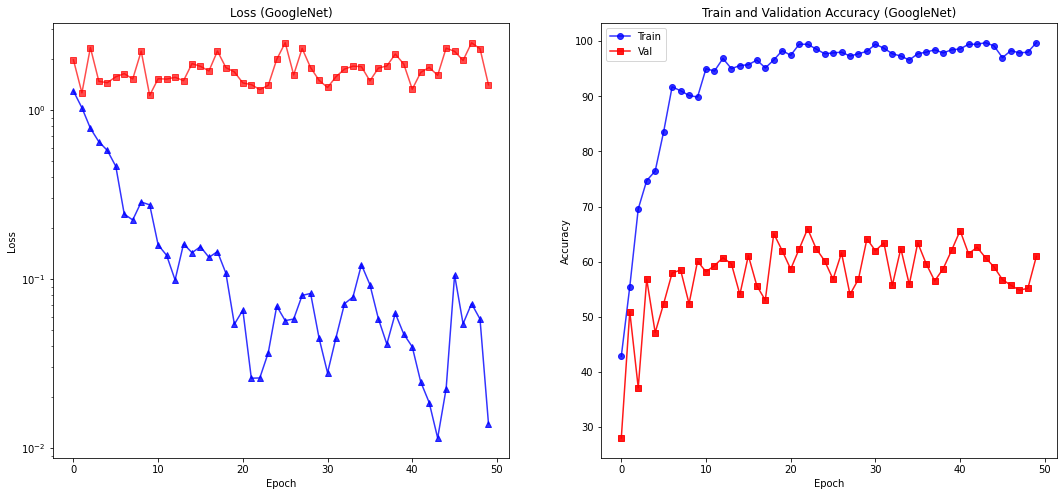

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plot loss
axs[0].plot(train_losses, 'b^-', alpha=.8)
axs[0].plot(val_losses, 'rs-', alpha=.7)
axs[0].set_yscale('log')
axs[0].set_title('Loss (GoogleNet)')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

axs[1].plot(train_acc, 'bo-', alpha=.8, label='Train')
axs[1].plot(val_acc, 'rs-', alpha=.9, label='Val')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Train and Validation Accuracy (GoogleNet)")
axs[1].legend()
plt.show()